In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [5]:
import MDAnalysis as mda
import prolif as plf
import numpy as np
import pandas as pd
from rdkit import DataStructs
import glob
from tqdm import tqdm
import os
import seaborn as sns
import datamol as dm
import rdkit
import matplotlib.pyplot as plt
import torch
import warnings
from rdkit.Chem import AllChem
from copy import deepcopy
import rdkit.Chem as Chem

from src.data.datasets import *
from src.utils.prolif import (
    merge_interaction_dfs,
    generate_interaction_df,
    calculate_interaction_similarity,
)

## Main

In [4]:
crossdocked = get_dataset("crossdocked")
zinc = get_dataset("zinc")
diffsbdd = get_dataset("diffsbdd")
targetdiff = get_dataset("targetdiff")
cvae = get_dataset("cvae")
sbdd = get_dataset("sbdd")
p2m = get_dataset("p2m")

flag = FLAGSamples()
decompdiff = DecompDiffSamples()

NameError: name 'get_dataset' is not defined

In [ ]:
from datamol.conformers._conformers import _get_ff


def calculate_energy(mol, forcefield="UFF", add_hs=True):
    mol = deepcopy(mol)

    if add_hs:
        mol = dm.add_hs(mol, add_coords=True)

    try:
        ff = _get_ff(mol, forcefield=forcefield)
    except:
        return np.nan

    energy = ff.CalcEnergy()

    return round(energy, 2)

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem


def merge_molecules_3d(mol1, mol2):
    merged = Chem.RWMol()

    # Add atoms from mol1 to the merged molecule
    for atom in mol1.GetAtoms():
        merged.AddAtom(atom)

    # Add atoms from mol2 to the merged molecule
    for atom in mol2.GetAtoms():
        merged.AddAtom(atom)

    # Add bonds from mol1 to the merged molecule
    for bond in mol1.GetBonds():
        atom1_idx = bond.GetBeginAtomIdx()
        atom2_idx = bond.GetEndAtomIdx()
        bond_type = bond.GetBondType()
        merged.AddBond(atom1_idx, atom2_idx, bond_type)

    # Add bonds from mol2 to the merged molecule
    for bond in mol2.GetBonds():
        atom1_idx = bond.GetBeginAtomIdx() + mol1.GetNumAtoms()
        atom2_idx = bond.GetEndAtomIdx() + mol1.GetNumAtoms()
        bond_type = bond.GetBondType()
        merged.AddBond(atom1_idx, atom2_idx, bond_type)

    # Combine the 3D conformations
    conf1 = mol1.GetConformer()
    conf2 = mol2.GetConformer()
    conf_merged = Chem.Conformer(mol1.GetNumAtoms() + mol2.GetNumAtoms())

    for i in range(conf1.GetNumAtoms()):
        conf_merged.SetAtomPosition(i, conf1.GetAtomPosition(i))

    for i in range(conf2.GetNumAtoms()):
        conf_merged.SetAtomPosition(i + mol1.GetNumAtoms(), conf2.GetAtomPosition(i))

    # Add the combined conformer to the merged molecule
    merged.AddConformer(conf_merged, assignId=True)

    return merged.GetMol()

In [ ]:
merged = []
for protein, lig in crossdocked:
    merged.append(merge_molecules_3d(protein, lig[0]))

In [15]:
crossdocked_paths = glob.glob(
    "/Users/charlie/projects/poses_benchmark/data/crossdocked/*" + ".sdf"
)
targetdiff_paths = glob.glob(
    "/Users/charlie/projects/poses_benchmark/data/benchmarks/targetdiff/*" + ".sdf"
)
targetdiff_paths

[]

In [7]:
crossdocked = []
for path in crossdocked_paths:
    crossdocked.extend(dm.read_sdf(path))

sbdd = []
for path in sbdd_paths:
    sbdd.extend(dm.read_sdf(path))

p2m = []
for path in p2m_paths:
    p2m.extend(dm.read_sdf(path))

cvae = []
for path in cvae_paths:
    cvae.extend(dm.read_sdf(path))

diffsbdd = []
for path in diffsbdd_paths:
    diffsbdd.extend(dm.read_sdf(path))

NameError: name 'crossdocked_paths' is not defined

In [7]:
print(len(crossdocked))
print(len(sbdd))
print(len(p2m))
print(len(cvae))
print(len(diffsbdd))

100
8220
11609
8186
9352


#### Remove radicals from DiffSBDD

In [24]:
def remove_radicals(mol):
    for atom in mol.GetAtoms():
        num_radicals = atom.GetNumRadicalElectrons()
        if num_radicals > 0:
            # Saturate with hydrogen atoms
            atom.SetNumExplicitHs(atom.GetNumExplicitHs() + num_radicals)
            atom.SetNumRadicalElectrons(0)

            # Alternatively, adjust the atom's formal charge and implicit valence
            # atom.SetFormalCharge(atom.GetFormalCharge() + num_radicals)
            # atom.SetNumRadicalElectrons(0)

    return mol


mol = remove_radicals(diffsbdd[10])
dm.add_hs(mol, add_coords=True)

/Users/charlie/projects/poses_benchmark/src/data/datasets.py:268: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  return 1(sdf_path)
/Users/charlie/projects/poses_benchmark/src/data/datasets.py:268: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  return 1(sdf_path)
/Users/charlie/projects/poses_benchmark/src/data/datasets.py:268: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  return 1(sdf_path)


NameError: name 'ligand_dir' is not defined

In [797]:
diffsbdd = [remove_radicals(m) for m in diffsbdd]

In [23]:
crossdocked[10]

ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues ARG 127  and LYS 129  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ARG 127  and LYS 129  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LYS 129  and THR 144  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LYS 129  and THR 144  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLU 146  and GLY 151  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLU 146  and GLY 151  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 151  and ALA 154  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 151  and ALA 154  in chain  A appear unbonded 
            and will be 

TypeError: 'int' object is not callable

In [10]:
from datamol.conformers._conformers import _get_ff


def calculate_energy(mol, forcefield="UFF", add_hs=True):
    mol = deepcopy(mol)

    if add_hs:
        mol = dm.add_hs(mol, add_coords=True)

    try:
        ff = _get_ff(mol, forcefield=forcefield)
    except:
        return np.nan

    energy = ff.CalcEnergy()

    return round(energy, 2)


crossdocked_energies = [calculate_energy(mol) for mol in crossdocked]
sbdd_energies = [calculate_energy(mol) for mol in sbdd]
p2m_energies = [calculate_energy(mol) for mol in p2m]
cvae_energies = [calculate_energy(mol) for mol in cvae]
diffsbdd_energies = [calculate_energy(mol) for mol in diffsbdd]
targetdiff_energies = [calculate_energy(mol) for mol in targetdiff]

diffsbdd_energies = [x for x in diffsbdd_energies if str(x) != "nan"]
# clip to 3000
diffsbdd_energies = [x if x < 10000 else 10000 for x in diffsbdd_energies]

RuntimeError: Pickling of "rdkit.Chem.rdmolfiles.SDMolSupplier" instances is not enabled (http://www.boost.org/libs/python/doc/v2/pickle.html)

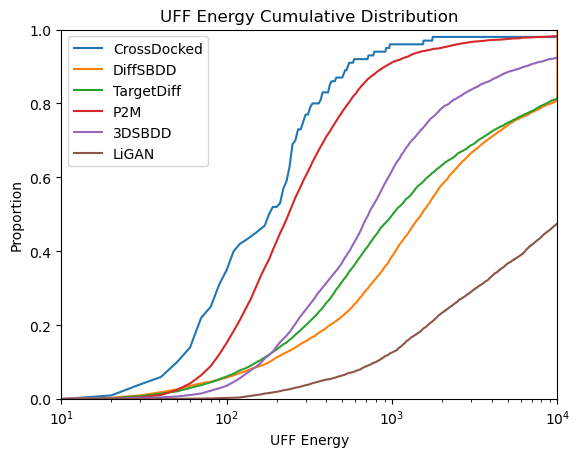

In [814]:
pallete = sns.palettes.color_palette("Set2")
# default matplotlib color cycle
pallete = plt.rcParams["axes.prop_cycle"].by_key()["color"]


def get_cdf(data):
    data = np.clip(data, None, 10**9)

    # getting data of the histogram
    count, bins_count = np.histogram(
        data, bins=100000, density=False, range=(-100, 10**6)
    )

    # finding the PDF of the histogram using count values
    pdf = count / sum(count)

    # using numpy np.cumsum to calculate the CDF
    # We can also find using the PDF values by looping and adding
    cdf = np.cumsum(pdf)

    return bins_count[1:], cdf


sbdd_bins, sbdd_cdf = get_cdf(sbdd_energies)
crossdocked_bins, crossdocked_cdf = get_cdf(crossdocked_energies)
p2m_bins, p2m_cdf = get_cdf(p2m_energies)
cvae_bins, cvae_cdf = get_cdf(cvae_energies)
diffsbdd_bins, diffsbdd_cdf = get_cdf(diffsbdd_energies)
targetdiff_bins, targetdiff_cdf = get_cdf(targetdiff_energies)

plt.plot(crossdocked_bins, crossdocked_cdf, label="CrossDocked", c=pallete[0])
plt.plot(diffsbdd_bins, diffsbdd_cdf, label="DiffSBDD", c=pallete[1])
plt.plot(targetdiff_bins, targetdiff_cdf, label="TargetDiff", c=pallete[2])
plt.plot(p2m_bins, p2m_cdf, label="P2M", c=pallete[3])
plt.plot(sbdd_bins, sbdd_cdf, label="3DSBDD", c=pallete[4])
plt.plot(cvae_bins, cvae_cdf, label="LiGAN", c=pallete[5])

# plt.xlim(0, 10000)

plt.xlim(10, 10000)
plt.ylim(0, 1)
plt.xlabel("UFF Energy")
plt.ylabel("Proportion")
plt.xscale("log")
plt.title("UFF Energy Cumulative Distribution")
plt.legend()
plt.savefig("figures/UFF_Energy_CDF.pdf")

### Without Hydrogens

In [ ]:
from datamol.conformers._conformers import _get_ff


def calculate_energy(mol, forcefield="UFF", add_hs=False):
    mol = deepcopy(mol)

    if add_hs:
        mol = dm.add_hs(mol)

    try:
        ff = _get_ff(mol, forcefield=forcefield)
    except:
        return np.nan

    energy = ff.CalcEnergy()

    return round(energy, 2)


crossdocked_energies = [calculate_energy(mol, add_hs=False) for mol in crossdocked]
sbdd_energies = [calculate_energy(mol) for mol in sbdd]
p2m_energies = [calculate_energy(mol) for mol in p2m]
cvae_energies = [calculate_energy(mol) for mol in cvae]
diffsbdd_energies = [calculate_energy(mol) for mol in diffsbdd]
targetdiff_energies = [calculate_energy(mol) for mol in targetdiff]

diffsbdd_energies = [x for x in diffsbdd_energies if str(x) != "nan"]
# clip to 3000
diffsbdd_energies = [x if x < 3000 else 3000 for x in diffsbdd_energies]

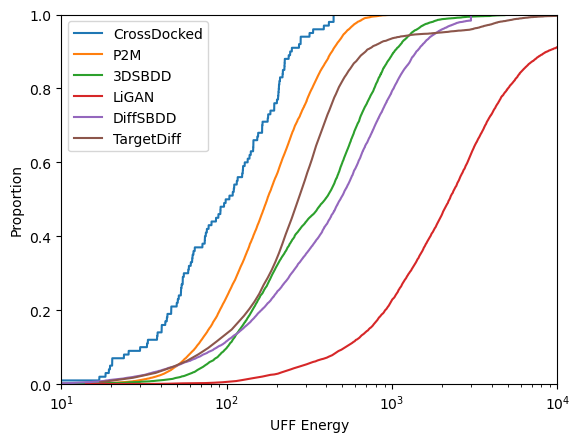

In [760]:
# remove nans
targetdiff_energies = [x for x in targetdiff_energies if str(x) != "nan"]


def get_cdf(data):
    """Summary: Returns the CDF of a list of data."""

    data = np.clip(data, None, 100000)

    # getting data of the histogram
    count, bins_count = np.histogram(data, bins=10000)  # range=(10**0,10**8))

    # finding the PDF of the histogram using count values
    pdf = count / sum(count)

    # using numpy np.cumsum to calculate the CDF
    # We can also find using the PDF values by looping and adding
    cdf = np.cumsum(pdf)

    return bins_count[1:], cdf


sbdd_bins, sbdd_cdf = get_cdf(sbdd_energies)
crossdocked_bins, crossdocked_cdf = get_cdf(crossdocked_energies)
p2m_bins, p2m_cdf = get_cdf(p2m_energies)
cvae_bins, cvae_cdf = get_cdf(cvae_energies)
diffsbdd_bins, diffsbdd_cdf = get_cdf(diffsbdd_energies)
targetdiff_bins, targetdiff_cdf = get_cdf(targetdiff_energies)

plt.plot(crossdocked_bins, crossdocked_cdf, label="CrossDocked")
plt.plot(p2m_bins, p2m_cdf, label="P2M")
plt.plot(sbdd_bins, sbdd_cdf, label="3DSBDD")
plt.plot(cvae_bins, cvae_cdf, label="LiGAN")
plt.plot(diffsbdd_bins, diffsbdd_cdf, label="DiffSBDD")
plt.plot(targetdiff_bins, targetdiff_cdf, label="TargetDiff")
# plt.xlim(0, 10000)

plt.xlim(10**1, 10**4)
plt.ylim(0, 1)
plt.xlabel("UFF Energy")
plt.ylabel("Proportion")
plt.xscale("log")
plt.legend()